In [188]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.linalg import solve, block_diag

module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path = os.path.abspath(os.path.join('../../data'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from dynamics import Dynamics
from utils import get_form_initial_conditions
from centralized_newton import CentralizedNewton

In [189]:
def position_estimation_error(X_est, X_true):
    return np.linalg.norm(X_est[:n_p, :, :] - X_true[:n_p, :, :], axis=0).flatten(), np.linalg.norm(X_est[n_x:n_x + n_p, :, :] - X_true[n_x:n_x + n_p, :, :], axis=0).flatten(), np.linalg.norm(X_est[2*n_x:2*n_x + n_p, :, :] - X_true[2*n_x:2*n_x + n_p, :, :], axis=0).flatten(), np.linalg.norm(X_est[3*n_x:3*n_x + n_p, :, :] - X_true[3*n_x:3*n_x + n_p, :, :], axis=0).flatten()

In [190]:
# Simulation parameters
dt = 60.0  # Time step [s]
K = 395  # Duration [min]
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6 
n_p = 3  
n = N * n_x
o = 3 + 3 + 2 + 1 
H = 15 # Window size [min]
invalid_rmse = 1e20 # [m]
grad_norm_order_mag = True
grad_norm_tol = 1e-6
max_iterations = 20
dyn = Dynamics()

In [191]:
# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P_0 = np.diag(np.concatenate([p_pos_initial * np.ones(3), p_vel_initial * np.ones(3)])) ** 2
P_0 = block_diag(P_0, P_0, P_0, P_0)

In [192]:
def plots(k, algorithm_class):
    iterations = np.arange(0, algorithm_class.iterations + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1
    axs[0].semilogy(iterations, 1 / H * np.array(algorithm_class.cost_values), '.-')
    axs[0].set_xlabel(r'$n$')
    axs[0].set_ylabel(r'$\frac{1}{H}J(x_n)$')
    axs[0].set_title('Normalized Cost Function') 
    axs[0].grid()

    # Plot 2
    axs[1].semilogy(iterations, 1 / H * np.array(algorithm_class.gradient_norm_values), '.-')
    axs[1].set_xlabel(r'$n$')
    axs[1].set_ylabel(r'$\frac{1}{H}||\nabla J(x_n)||_2$')
    axs[1].set_title('Normalized Gradient Norm')
    axs[1].grid()
    
    fig.suptitle(f'Solving MHE problem J(k) with k = {k}', fontsize=14)

    plt.tight_layout()
    plt.show()

In [193]:
# Seed for reproducibility
np.random.seed(42)

# Initial conditions for the state vector and true state vectors
X_initial = get_form_initial_conditions(formation)
with open(f"../../data/tudatpy_form{formation}.pkl", "rb") as file:
    X_true = pickle.load(file)[:, :, :K]

# Initial position estimation error
X_est = np.zeros_like(X_true)
X_est[:, :, 0] = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))
for k in range(K - 1):
    X_est[:, :, k + 1] = dyn.f(dt, X_est[:, :, k])
position_estimation_error_1_initial, position_estimation_error_2_initial, position_estimation_error_3_initial, position_estimation_error_4_initial = position_estimation_error(X_est, X_true)

# Algorithm class to use
centralized_newton = CentralizedNewton(H, K, o, R, grad_norm_order_mag, grad_norm_tol, max_iterations)

# Observations
Y = np.zeros((o, 1, K))
for k in range(K):
    Y[:, :, k] = centralized_newton.h(X_true[:, :, k]) + np.random.multivariate_normal(np.zeros(o), R).reshape((o, 1))

In [194]:
first_round_stop_iteration = []
K_minus_H_next_rounds_stop_iteration = []

# Cold-start
x_init = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))

# Apply the algorithm
X_est = np.zeros((n, 1, K))
for k in tqdm(range(H - 1, K), desc="Windows", leave=False):
    centralized_newton.cost_values, centralized_newton.gradient_norm_values = [], []
    x_init, x_est = centralized_newton.solve(k, dt, Y, x_init, X_true[:, :, k - H + 1],  X_true[:, :, k])
    X_est[:, :, k] = x_est
    
    plots(k, centralized_newton)

    if k == H - 1: # Check divergence in the beginning
        position_estimation_error_init_1, position_estimation_error_init_2, position_estimation_error_init_3, position_estimation_error_init_4 = [], [], [], []
        x_est_tau = x_est
        for tau in range(H):
            position_estimation_error_init_1.append(np.linalg.norm(x_est_tau[:n_p, :] - X_true[:n_p, :, tau]))
            position_estimation_error_init_2.append(np.linalg.norm(x_est_tau[n_x:n_x + n_p, :] - X_true[n_x:n_x + n_p, :, tau]))
            position_estimation_error_init_3.append(np.linalg.norm(x_est_tau[2*n_x:2*n_x + n_p, :] - X_true[2*n_x:2*n_x + n_p, :, tau]))    
            position_estimation_error_init_4.append(np.linalg.norm(x_est_tau[3*n_x:3*n_x + n_p, :] - X_true[3*n_x:3*n_x + n_p, :, tau]))
            x_est_tau = dyn.f(dt, x_est_tau)
        rmse_init_1 = np.sqrt(np.mean(np.array(position_estimation_error_init_1) ** 2))
        rmse_init_2 = np.sqrt(np.mean(np.array(position_estimation_error_init_2) ** 2))
        rmse_init_3 = np.sqrt(np.mean(np.array(position_estimation_error_init_3) ** 2))
        rmse_init_4 = np.sqrt(np.mean(np.array(position_estimation_error_init_4) ** 2))
        if rmse_init_1 > invalid_rmse or rmse_init_2 > invalid_rmse or rmse_init_3 > invalid_rmse or rmse_init_4 > invalid_rmse:
            print(f"This Monte Carlo run diverged!")
        else:
            first_round_stop_iteration = centralized_newton.iterations
    else:
        K_minus_H_next_rounds_stop_iteration.append(centralized_newton.iterations)

    # Warm-start
    x_init = dyn.f(dt, x_init)

# After each Monte Carlo Run compute the RMSE_m for each K - H + 1 timestamps
position_estimation_error_1, position_estimation_error_2, position_estimation_error_3, position_estimation_error_4 = [], [], [], []
for k in range(H - 1, K):
    position_estimation_error_1.append(np.linalg.norm(X_est[:n_p, :, k] - X_true[:n_p, :, k]))
    position_estimation_error_2.append(np.linalg.norm(X_est[n_x:n_x + n_p, :, k] - X_true[n_x:n_x + n_p, :, k]))
    position_estimation_error_3.append(np.linalg.norm(X_est[2*n_x:2*n_x + n_p, :, k] - X_true[2*n_x:2*n_x + n_p, :, k]))
    position_estimation_error_4.append(np.linalg.norm(X_est[3*n_x:3*n_x + n_p, :, k] - X_true[3*n_x:3*n_x + n_p, :, k]))
rmse_1 = np.sqrt(np.mean(np.array(position_estimation_error_1) ** 2))
rmse_2 = np.sqrt(np.mean(np.array(position_estimation_error_2) ** 2))
rmse_3 = np.sqrt(np.mean(np.array(position_estimation_error_3) ** 2))
rmse_4 = np.sqrt(np.mean(np.array(position_estimation_error_4) ** 2))
print(f'This Monte Carlo run RMSE for {K - H + 1} timestamps:')
print(f'RMSE_1 = {np.mean(rmse_1)}\nRMSE_2 = {np.mean(rmse_2)}\nRMSE_3 = {np.mean(rmse_3)}\nRMSE_4 = {np.mean(rmse_4)}')
print(f'CentralizedNewton applied to J(H - 1) converged with {first_round_stop_iteration} iterations.')
print(f'CentralizedNewton applied to J(k) with k = H, ..., K - 1 converged with {np.mean(K_minus_H_next_rounds_stop_iteration)} iterations on average.')

Windows:   0%|          | 0/381 [00:00<?, ?it/s]

Before applying the algorithm
Cost function: 61611646.6594562
Gradient norm: 182962510.0793379
Global estimation error: 429.5049051950654
Initial conditions estimation errors: 272.4697073631671 m, 173.20827048056321 m, 227.77973283351287 m, 168.3746081658613 m
Position estimation errors: 305.26899578200727 m, 399.1013461693938 m, 263.0479845054427 m, 172.6405200592991 m\CFG.n
Iteration 1
Cost function: 65698.85382824011 (-99.89%)
Gradient norm: 300988.5134710563 (-99.84%)
Global estimation error: 450.6532191256752 (4.92%)
Initial conditions estimation errors: 13.457773414147931 m, 229.74434177685248 m, 294.72298622908454 m, 251.52128300917548 m
Position estimation errors: 10.378321067774872 m, 81.08126988826878 m, 133.0998660255001 m, 285.33494783169044 m\CFG.n
Iteration 2
Cost function: 65801.62076414109 (0.16%)
Gradient norm: 212273.7873238169 (-29.47%)
Global estimation error: 432.58976738951765 (-4.01%)
Initial conditions estimation errors: 13.455127136635943 m, 162.7792345218979 m

KeyboardInterrupt: 

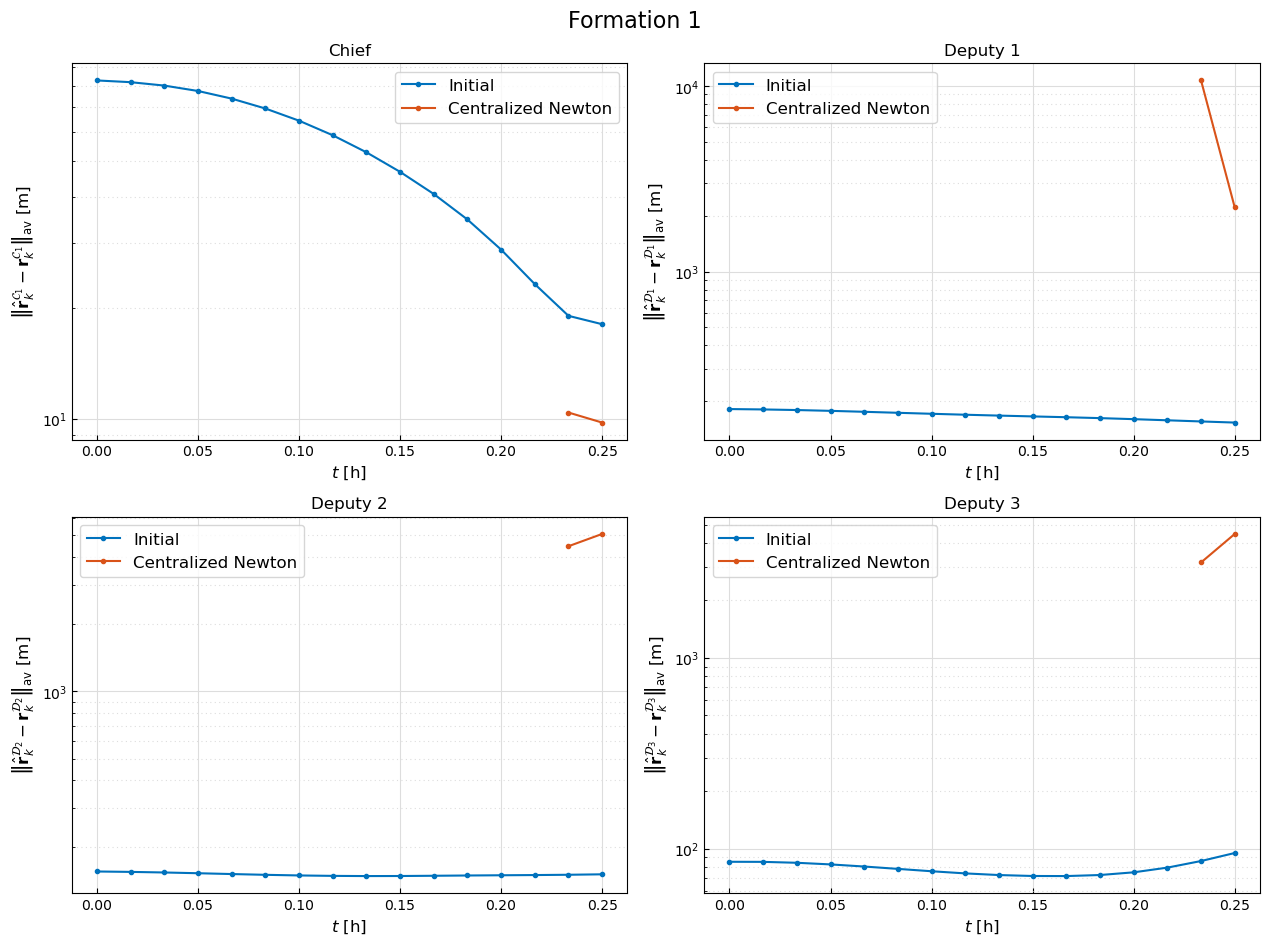

In [ ]:
# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, K) / dt
algorithm = "Centralized Newton"

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, position_estimation_error_1_initial, ".-", label="Initial")
axs[0, 0].plot(time[H - 1:], position_estimation_error_1, ".-", label=algorithm)
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{C}_1} - \\mathbf{r}_k^{\\mathcal{C}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)
axs[0, 0].set_title("Chief")

# Plot 2: Deputy 1
axs[0, 1].plot(time, position_estimation_error_2_initial, ".-", label="Initial")
axs[0, 1].plot(time[H - 1:], position_estimation_error_2, ".-", label=algorithm)
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_1} - \\mathbf{r}_k^{\\mathcal{D}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)
axs[0, 1].set_title("Deputy 1")

# Plot 3: Deputy 2
axs[1, 0].plot(time, position_estimation_error_3_initial, ".-", label="Initial")
axs[1, 0].plot(time[H - 1:], position_estimation_error_3, ".-", label=algorithm)
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_2} - \\mathbf{r}_k^{\\mathcal{D}_2}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)
axs[1, 0].set_title("Deputy 2")

# Plot 4: Deputy 3
axs[1, 1].plot(time, position_estimation_error_4_initial, ".-", label="Initial")
axs[1, 1].plot(time[H - 1:], position_estimation_error_4, ".-", label=algorithm)
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_3} - \\mathbf{r}_k^{\\mathcal{D}_3}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)
axs[1, 1].set_title("Deputy 3")

fig.suptitle(f"Formation {formation}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()